### Importation des données

In [1]:
! pip install pdfminer.six

In [2]:
import pdfminer
#print(pdfminer.__version__)  

In [24]:
from pdfminer.high_level import extract_text

plan_2030 = pdfminer.high_level.extract_text(r'./elysee-module-18543-fr.pdf',
                         password='', 
                         page_numbers=None, maxpages=0, 
                         caching=True, codec='utf-8', laparams=None)

#ecologie = extract_text(r'C:/Users/ADSL/Downloads/elysee-module-18348-fr.pdf')
#séparatisme = extract_text(r'C:/Users/ADSL/Downloads/elysee-module-16114-fr.pdf')
#santé = extract_text(r'C:/Users/ADSL/Downloads/elysee-module-15678-fr.pdf')

### Stopwords

In [25]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import spacy
from spacy.matcher import Matcher #class pour réalisation du matching
from spacy.matcher import PhraseMatcher
from spacy.language import Language
from spacy.tokens import Span #class pour extraction des mots
from joblib import Parallel, delayed
from spacy.symbols import nsubj, VERB
from spacy import displacy

import pandas as pd
import numpy as np

from collections import Counter
from glob import glob
import matplotlib.pyplot as plt


from tqdm import tqdm

from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
%matplotlib inline

import seaborn
import regex as re
import pandas as pd

In [27]:
#importation du modèle spacy
#nlp = spacy.load(r'C:/Users/ADSL\Anaconda43/Lib/site-packages/fr_core_news_sm/fr_core_news_sm-3.0.0') # segur
nlp_fr = spacy.load('fr_core_news_sm')
print ('Importation du dictionnaire de stopwords SPACY')
from spacy.lang.fr.stop_words import STOP_WORDS
print("Liste de stopwords français de SPACY a %d entrées" % len(nlp_fr.Defaults.stop_words))
print ('\n')
print ('Importation du dictionnaire perso')
custom_stop_words = []
with open( r'./dictionnaire_v13102021.txt', "r", encoding='utf8') as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )
print("Liste de stopwords du dictionnaire perso a %d entrées" % len(custom_stop_words))
custom_stop_words_final = set(custom_stop_words)
#[sw for sw in custom_stop_words if len(sw) == 1]
print ('\n')
print ('Importation du dictionnaire NLTK')
from nltk.corpus import stopwords
stopwords_fr = set(stopwords.words('french'))
print("Liste de stopwords de NLTK a %d entrées" % len(stopwords_fr))
print ('\n')
print ('Importation du dictionnaire GENSIM (stopwords anglo-saxons)')
from gensim.parsing.preprocessing import STOPWORDS # Anglais
print("Liste de stopwords de GENSIM a %d entrées" % len(STOPWORDS))

custom = ["qu", "/" ,"//"]

STOP_WORDS = nlp_fr.Defaults.stop_words.union(custom).union(stopwords_fr).union(STOPWORDS).union(custom_stop_words_final)

#ajout
STOP_WORDS |= {".pdf",'élécharger','C’'}
#suppression
STOP_WORDS -= {"salon"}
print ('\n')
print("Liste définitive de stopwords a %d entrées" % len(STOP_WORDS))
print ('\n')
print("Liste finale des mots clés supprimés automatiquement")
print(sorted(STOP_WORDS))

Importation du dictionnaire de stopwords SPACY
Liste de stopwords français de SPACY a 507 entrées


Importation du dictionnaire perso
Liste de stopwords du dictionnaire perso a 489 entrées


Importation du dictionnaire NLTK
Liste de stopwords de NLTK a 157 entrées


Importation du dictionnaire GENSIM (stopwords anglo-saxons)
Liste de stopwords de GENSIM a 337 entrées


Liste définitive de stopwords a 1054 entrées


Liste finale des mots clés supprimés automatiquement
['.pdf', '/', '//', 'C’', 'a', 'abord', 'about', 'above', 'across', 'afin', 'after', 'afterwards', 'again', 'against', 'ah', 'ai', 'aie', 'aient', 'aies', 'ainsi', 'ait', 'al', 'all', 'allaient', 'aller', 'allo', 'allons', 'allé', 'almost', 'alone', 'along', 'alors', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'amp', 'an', 'and', 'another', 'ans', 'anterieur', 'anterieure', 'anterieures', 'antérieur', 'antérieure', 'antérieures', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 

### Post-traitement importation

In [28]:
plan_2030 = re.sub(r"\n\n", " ", plan_2030)  # suppression des espaces
plan_2030 = re.sub(r'[A-Z]+(?![a-z])', '', plan_2030) # des mots en majuscule
plan_2030 = re.sub('http\S+\s*', '', plan_2030)
plan_2030  = re.sub(r'\nélécharger', '', plan_2030)
plan_2030  = re.sub(r'.pdf', '', plan_2030)
plan_2030 = re.sub(r'\s+', ' ', plan_2030) #suppression des extra "white spaces"
plan_2030 = re.sub(r'\b\w{1}\b', '', plan_2030)  # suppression des éléments inférieurs à 2 charactères
plan_2030 = re.sub(r"\'", " ", plan_2030)  # supprimme les apostrophes
plan_2030 = re.sub(r",", " ", plan_2030)  # supprimme les virgules
plan_2030 = re.sub(r"\W", " ", plan_2030, flags=re.I)
plan_2030_clean = plan_2030.lower()

import re
pattern = re.compile(r'\b(' + r'|'.join(STOP_WORDS) + r')\b\s*')
plan_2030_clean = pattern.sub('', plan_2030_clean)

In [29]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
print("\n")
tokenized_discours = tokenizer.tokenize(plan_2030_clean)
print(tokenized_discours)



['12', '2021', '2030', 'monsieur', 'ministre', 'mesdames', 'messieurs', 'ministres', 'monsieur', 'commissaire', 'plan', 'mesdames', 'messieurs', 'parlementaires', 'mesdames', 'messieurs', 'grades', 'qualité', 'amis', 'aujourd', 'elysée', 'moment', 'particulier', 'essayer', 'projeter', 'loin', 'moment', 'concourent', 'sorte', 'regarder', 'côté', 'bonne', 'vertu', 'personnelle', 'mentale', 'pays', 'travers', 'prises', 'paroles', 'illustré', 'convictions', 'convictions', 'personnelles', 'rendu', 'compte', 'travail', 'contributrices', 'contributeurs', 'salle', 'préparé', 'stratégie', 'travail', 'collectif', 'étudiantes', 'étudiants', 'chercheuses', 'chercheurs', 'universitaires', 'responsables', 'organisations', 'branches', 'professionnelles', 'syndicales', 'entrepreneuses', 'entrepreneurs', 'investisseurs', 'parlementaires', 'évidemment', 'ministres', 'piloté', 'travail', 'remercie', 'ensemble', 'grands', 'organismes', 'recherche', 'politique', 'économique', 'industrielle', 'essayer', '

In [30]:
finals = [t for t in tokenized_discours if t not in STOP_WORDS]

In [31]:
import nltk
bigrams = list([' '.join(bg) for bg in nltk.bigrams(finals)])

In [32]:
trigrams = list([' '.join(bg) for bg in nltk.trigrams(finals)])

In [33]:
ug_fdist = nltk.FreqDist(finals)
bg_fdist = nltk.FreqDist(bigrams)
trig_fdist = nltk.FreqDist(trigrams)

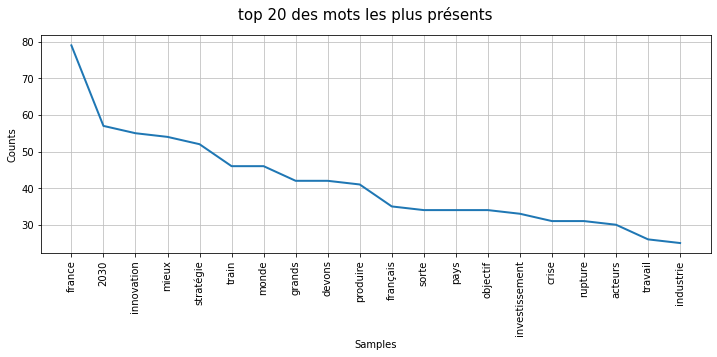

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [34]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(4)
f.suptitle('top 20 des mots les plus présents', fontsize=15)
display(ug_fdist.plot(20))

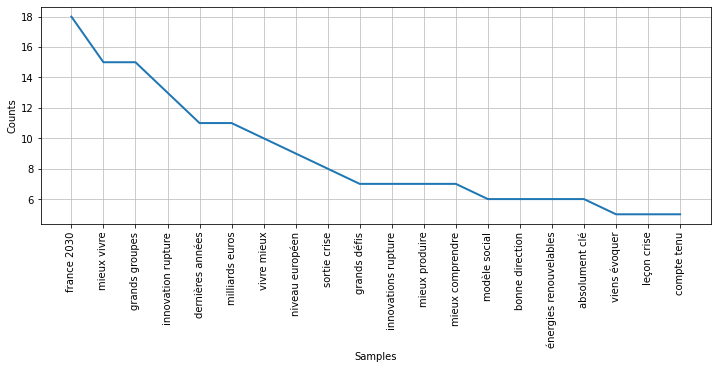

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [35]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(4)
display(bg_fdist.plot(20))

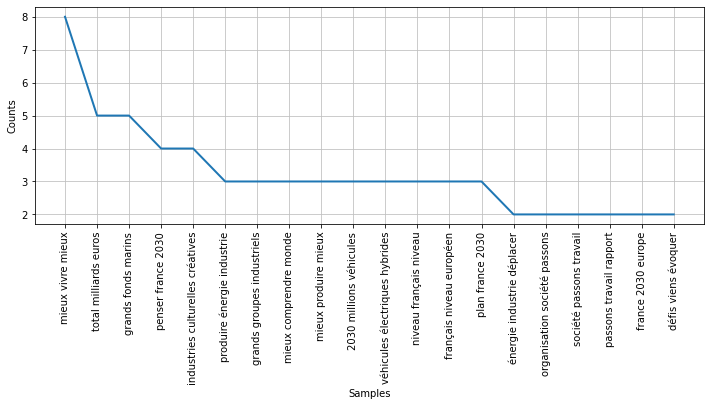

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [36]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(4)
display(trig_fdist.plot(20))

In [37]:
from collections import Counter
counter= Counter(finals)
print(counter.most_common(200))

[('france', 79), ('2030', 57), ('innovation', 55), ('mieux', 54), ('stratégie', 52), ('train', 46), ('monde', 46), ('grands', 42), ('devons', 42), ('produire', 41), ('français', 35), ('sorte', 34), ('pays', 34), ('objectif', 34), ('investissement', 33), ('crise', 31), ('rupture', 31), ('acteurs', 30), ('travail', 26), ('industrie', 25), ('vivre', 25), ('clé', 25), ('modèle', 23), ('aujourd', 22), ('recherche', 22), ('objectifs', 22), ('plan', 21), ('continuer', 21), ('grandes', 21), ('justement', 21), ('années', 20), ('vite', 20), ('accélérer', 20), ('niveau', 20), ('investir', 20), ('santé', 20), ('manière', 19), ('choix', 18), ('milliards', 18), ('industrielle', 17), ('nation', 17), ('défis', 17), ('ailleurs', 17), ('française', 17), ('euros', 17), ('essayer', 16), ('dernières', 16), ('ensuite', 16), ('production', 16), ('européen', 16), ('filières', 16), ('ensemble', 15), ('crois', 15), ('chose', 15), ('termes', 15), ('groupes', 15), ('secteurs', 15), ('particulier', 14), ('importan

In [42]:
from textblob import TextBlob
#For unigram : Use n = 1
TextBlob(plan_2030_clean).ngrams(2)


[WordList(['12', '2021']),
 WordList(['2021', '2030']),
 WordList(['2030', 'monsieur']),
 WordList(['monsieur', 'ministre']),
 WordList(['ministre', 'mesdames']),
 WordList(['mesdames', 'messieurs']),
 WordList(['messieurs', 'ministres']),
 WordList(['ministres', 'monsieur']),
 WordList(['monsieur', 'commissaire']),
 WordList(['commissaire', 'plan']),
 WordList(['plan', 'mesdames']),
 WordList(['mesdames', 'messieurs']),
 WordList(['messieurs', 'parlementaires']),
 WordList(['parlementaires', 'mesdames']),
 WordList(['mesdames', 'messieurs']),
 WordList(['messieurs', 'grades']),
 WordList(['grades', 'qualité']),
 WordList(['qualité', 'amis']),
 WordList(['amis', 'aujourd']),
 WordList(['aujourd', 'elysée']),
 WordList(['elysée', 'moment']),
 WordList(['moment', 'particulier']),
 WordList(['particulier', 'essayer']),
 WordList(['essayer', 'projeter']),
 WordList(['projeter', 'loin']),
 WordList(['loin', 'moment']),
 WordList(['moment', 'concourent']),
 WordList(['concourent', 'sorte']),

In [41]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/gauguierjean-
[nltk_data]     jacques/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
counter = Counter(bigrams)
print(counter.most_common(200))

[('france 2030', 18), ('mieux vivre', 15), ('grands groupes', 15), ('innovation rupture', 13), ('dernières années', 11), ('milliards euros', 11), ('vivre mieux', 10), ('niveau européen', 9), ('sortie crise', 8), ('grands défis', 7), ('innovations rupture', 7), ('mieux produire', 7), ('mieux comprendre', 7), ('modèle social', 6), ('bonne direction', 6), ('énergies renouvelables', 6), ('absolument clé', 6), ('viens évoquer', 5), ('leçon crise', 5), ('compte tenu', 5), ('loi programmation', 5), ('plan france', 5), ('point clé', 5), ('nouvelles filières', 5), ('total milliards', 5), ('évoquais heure', 5), ('grands fonds', 5), ('fonds marins', 5), ('10 objectifs', 5), ('mesdames messieurs', 4), ('travail collectif', 4), ('organismes recherche', 4), ('produire énergie', 4), ('penser france', 4), ('horizon 2030', 4), ('dépense publique', 4), ('train transformer', 4), ('croissance potentielle', 4), ('enseignement supérieur', 4), ('france relance', 4), ('stratégie 2030', 4), ('grande nation', 4

###  Topic Modeling

### SPACY

In [44]:
# importation des données
from glob import glob
from pdfminer.high_level import extract_text
pdf_files = glob(r'./elysee-module-18543-fr.pdf')
text = extract_text(pdf_files[0])

In [45]:
lines = text.split('\n')
cleaned_lines = []
for ln in lines:
    if len(ln) == 0:
        continue
    if ln[-1] == '-':
         cleaned_lines.append(ln[:-1])
    else:
        cleaned_lines.append(ln + ' ')

cleaned = ''.join(cleaned_lines)

In [46]:
doc = nlp_fr(cleaned)

In [64]:
doc

12 OCTOBRE 2021 - SEUL LE PRONONCÉ FAIT FOI DISCOURS DU PRÉSIDENT DE LA RÉPUBLIQUE À L’OCCASION DE LA PRÉSENTATION DU PLAN FRANCE 2030 Télécharger le .pdf Monsieur le Premier ministre, Mesdames Messieurs les ministres, Monsieur le haut commissaire au plan, Mesdames Messieurs les parlementaires, Mesdames et Messieurs en vos grades et qualité, chers amis, merci d'être aujourd'hui à l'Elysée pour ce moment un peu particulier. D'abord parce qu'on va essayer de se projeter loin dans un moment où beaucoup nous concourent en quelque sorte à nous faire regarder à côté. Et je pense que c'est d'abord une bonne vertu personnelle, mentale, et c'est aussi très bon pour un pays comme le nôtre. Merci, parce qu'à travers vos 5 prises de paroles, vous avez illustré des convictions qui sont vos convictions personnelles. Mais vous avez un peu aussi rendu compte de tout le travail qui a été fait par celles et ceux, vous en êtes les contributrices et contributeurs dans cette salle, qui ont préparé depuis d

In [67]:
for ent in doc.ents :
    if len(ent.text) > 2:
        print(ent.text, ent.start_char, ent.end_char, ent.label_, spacy.explain(ent.label_))

OCTOBRE 2021 3 15 MISC Miscellaneous entities, e.g. events, nationalities, products or works of art
PRÉSIDENT 56 65 ORG Companies, agencies, institutions, etc.
Télécharger 135 146 PER Named person or family.
Monsieur 155 163 PER Named person or family.
Premier ministre 167 183 MISC Miscellaneous entities, e.g. events, nationalities, products or works of art
Mesdames Messieurs 185 203 PER Named person or family.
Monsieur 219 227 PER Named person or family.
Mesdames 296 304 LOC Non-GPE locations, mountain ranges, bodies of water
Messieurs 308 317 LOC Non-GPE locations, mountain ranges, bodies of water
l'Elysée 383 391 LOC Non-GPE locations, mountain ranges, bodies of water
Merci 689 694 MISC Miscellaneous entities, e.g. events, nationalities, products or works of art
la France 1805 1814 LOC Non-GPE locations, mountain ranges, bodies of water
Europe 1823 1829 LOC Non-GPE locations, mountain ranges, bodies of water
BLANCHARD 2048 2057 ORG Companies, agencies, institutions, etc.
TIROLE 2061

In [70]:
# document level
ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
print(ents)

# token level
ent_san = [doc[2].text, doc[2].ent_iob_, doc[2].ent_type_]
print(ent_san)

[('OCTOBRE 2021', 3, 15, 'MISC'), ('PRÉSIDENT', 56, 65, 'ORG'), ('Télécharger', 135, 146, 'PER'), ('Monsieur', 155, 163, 'PER'), ('Premier ministre', 167, 183, 'MISC'), ('Mesdames Messieurs', 185, 203, 'PER'), ('Monsieur', 219, 227, 'PER'), ('Mesdames', 296, 304, 'LOC'), ('Messieurs', 308, 317, 'LOC'), ("l'Elysée", 383, 391, 'LOC'), ('Merci', 689, 694, 'MISC'), ('la France', 1805, 1814, 'LOC'), ('Europe', 1823, 1829, 'LOC'), ('BLANCHARD', 2048, 2057, 'ORG'), ('TIROLE', 2061, 2067, 'ORG'), ('c’', 2825, 2827, 'LOC'), ('la France', 3703, 3712, 'LOC'), ('Ça', 5127, 5129, 'MISC'), ('l’hyperfinanciarisation', 5448, 5471, 'MISC'), ('C’', 5578, 5580, 'MISC'), ('l’', 5734, 5736, 'ORG'), ('j’', 5850, 5852, 'ORG'), ('C’', 6124, 6126, 'MISC'), ('C’', 7331, 7333, 'MISC'), ('la France', 7427, 7436, 'LOC'), ('Europe', 7448, 7454, 'LOC'), ('l’', 7689, 7691, 'ORG'), ('Covid', 7749, 7754, 'LOC'), ('la France', 8039, 8048, 'LOC'), ('n’', 10180, 10182, 'PER'), ('France', 10702, 10708, 'LOC'), ("l'Europe",

### Part of Speech Tagging

In [48]:
spacy_adj = [tok for tok in doc if tok.pos_ == 'ADJ' and not tok.is_stop and not tok.is_punct] #adjectifs
spacy_adj_count = Counter([tok.text.lower() for tok in spacy_adj]).most_common(20)
spacy_adj_count

[('grands', 41),
 ('français', 28),
 ('grandes', 21),
 ('industrielle', 17),
 ('française', 17),
 ('dernières', 16),
 ('européen', 15),
 ('particulier', 14),
 ('important', 14),
 ('industriel', 14),
 ('bonne', 13),
 ('nouveaux', 13),
 ('industriels', 12),
 ('européenne', 10),
 ('technologiques', 9),
 ('clé', 9),
 ('grande', 8),
 ('nouvelles', 8),
 ('collectif', 7),
 ('collective', 7)]

In [55]:
spacy_verb = [tok for tok in doc if tok.pos_ == 'VERB' and not tok.is_punct and not tok.is_stop] #verbes # and not tok.is_stop
spacy_verb_count = Counter([tok.text.strip() for tok in spacy_verb]).most_common(30)
spacy_verb_count

[('faut', 77),
 ('faire', 52),
 ('devons', 42),
 ('produire', 36),
 ('continuer', 21),
 ('accélérer', 20),
 ('investir', 20),
 ('veut', 18),
 ('vivre', 17),
 ('essayer', 16),
 ('crois', 15),
 ('aller', 14),
 ('réussir', 14),
 ('créer', 13),
 ('commencé', 13),
 ('évoquais', 13),
 ('pouvoir', 13),
 ('permettre', 12),
 ('voit', 11),
 ('viens', 10),
 ('construire', 10),
 ('développer', 10),
 ('produit', 9),
 ('agit', 9),
 ('comprendre', 9),
 ('pouvons', 9),
 ('nourrir', 9),
 ('sécuriser', 9),
 ('projeter', 8),
 ('consolider', 8)]

In [60]:
entites = [ent.text.lower() for ent in doc.ents if ent.text.lower() not in STOP_WORDS]
entites_count = Counter(entites).most_common(50)
entites_count

[('la france', 43),
 ('france', 24),
 ('europe', 7),
 ('français', 6),
 ("l'europe", 5),
 ('–', 5),
 ('de france', 4),
 ('françaises', 4),
 ('jamais', 3),
 ('gouvernement', 3),
 ('européens', 3),
 ('france 2030', 3),
 ('monsieur', 2),
 ('premier ministre', 2),
 ('mesdames', 2),
 ('messieurs', 2),
 ('plan france', 2),
 ('paris', 2),
 ('l’électrolyse', 2),
 ('l’hydrogène', 2),
 ('france relance', 2),
 ('pia', 2),
 ('etat', 2),
 ('deeptech', 2),
 ('octobre 2021', 1),
 ('président', 1),
 ('télécharger', 1),
 ('mesdames messieurs', 1),
 ("l'elysée", 1),
 ('blanchard', 1),
 ('tirole', 1),
 ('l’hyperfinanciarisation', 1),
 ('covid', 1),
 ('l’oublie', 1),
 ('l’humanité', 1),
 ('jusqu’', 1),
 ('coopération internationale et européenne', 1),
 ('l’innovation de rupture', 1),
 ('l’innovation', 1),
 ('l’assurance chômage', 1),
 ('shangaï', 1),
 ('les anglo-saxons', 1),
 ('l’hypertechnologie', 1),
 ('xxème', 1),
 ('deep tech', 1),
 ('baisse', 1),
 ('éric', 1),
 ('affaires', 1),
 ('l’éducation', 1),


In [63]:
entites = [ent.text.lower() for ent in doc.ents if ent.text.lower() not in STOP_WORDS and ent.label_ == "ORG"]
entites_count = Counter(entites).most_common(50)
entites_count

[('–', 4),
 ('france 2030', 3),
 ('france relance', 2),
 ('pia', 2),
 ('président', 1),
 ('blanchard', 1),
 ('tirole', 1),
 ('l’humanité', 1),
 ('coopération internationale et européenne', 1),
 ('européen', 1),
 ('air liquide', 1),
 ('union européenne', 1),
 ("agence d'innovation", 1),
 ('amazon', 1),
 ('disney', 1),
 ('eti', 1),
 ('parlement', 1),
 ('y%', 1),
 ('faites-moi plaisir', 1)]

In [64]:
def adjectivesDescribingCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.text] # filtrage sur les phrases
    adjectives = []
    for sent in sents: 
        for word in sent: 
            if character in word.text: # filtrage sur les mots
                for child in word.children: # filtrage sur les mots 
                    if child.pos_ == 'ADJ' and not child.is_stop :  # filtrage sur les mots #and not child.is_stop
                        adjectives.append(child.text.strip())
    return Counter(adjectives).most_common(10)

In [70]:
adjectivesDescribingCharacters(doc, 'industrie')

[('automobile', 4),
 ('culturelles', 4),
 ('grands', 2),
 ('française', 2),
 ('créative', 1),
 ('historiques', 1),
 ('euxmêmes', 1),
 ('agricole', 1),
 ('ouvertes', 1),
 ('géographique', 1)]

In [72]:
adjectivesDescribingCharacters(doc, 'technologie')

[('numériques', 2), ('utiles', 1), ('souveraines', 1)]

In [78]:
 def verbsForCharacters(text, character):
    sents = [sent for sent in doc.sents if character in sent.text] #filtrage
    charWords = []
    for sent in sents: 
        for word in sent: 
            if character in word.text: 
                charWords.append(word)
    charVerbs = []
    for word in charWords: 
        # Start walking up the list of ancestors 
        # Until we get to the first verb. 
        for ancestor in word.ancestors: 
            if ancestor.pos_.startswith('V'): 
                charVerbs.append(ancestor.lemma_.strip())
                #charVerbs.append(ancestor.text.strip())
    return Counter(charVerbs).most_common(30)

In [79]:
 verbsForCharacters(doc, 'emploi')

[('continuer', 3),
 ('détruire', 2),
 ('être', 2),
 ('avoir', 2),
 ('créer', 2),
 ('transformer', 1),
 ('commencer', 1),
 ('dire', 1),
 ('pouvoir', 1),
 ('croire', 1),
 ('accélérer', 1),
 ('recréer', 1),
 ('arrive', 1)]

In [83]:
 verbsForCharacters(doc, 'innovation')

[('avoir', 18),
 ('falloir', 6),
 ('être', 5),
 ('pouvoir', 4),
 ('devoir', 4),
 ('considérer', 3),
 ('pense', 3),
 ('lier', 3),
 ('tirer', 3),
 ('perdre', 3),
 ('dire', 3),
 ('vivre', 2),
 ('savoir', 2),
 ('prendre', 2),
 ('retrouver', 2),
 ('commencer', 2),
 ('continuer', 2),
 ('vouloir', 2),
 ('bâtir', 2),
 ('tuer', 2),
 ('appeler', 1),
 ('c’', 1),
 ('exacerber', 1),
 ('assister', 1),
 ('participer', 1),
 ('produire', 1),
 ('convaincre', 1),
 ('impose', 1),
 ('désindustrialiser', 1),
 ('penser', 1)]